In [1]:
import torch
import random
import gc
import dataclasses
import tqdm
import os

import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForCausalLM

def load_model_and_tokenizer(gpu_num, model_name="meta-llama/Llama-2-7b-chat-hf"):
    device = torch.device(f"cuda:{gpu_num}")
    model = AutoModelForCausalLM.from_pretrained(
        model_name, cache_dir="/data2/sjeromeh/cache/pretrained_models"
    ).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="/data2/sjeromeh/cache/pretrained_models")
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.eval()
    return model, tokenizer


def clear_hooks(input_hooks):
    for hook in input_hooks:
        hook.remove()
    input_hooks = []
    gc.collect()

/home/sjeromeh/anaconda3/envs/generalize/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/sjeromeh/anaconda3/envs/generalize/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load model and tokenizer

In [ ]:
# Choose model here
# Options are keys of model_names dict below
model_alias = "llama-3-1"

model_names = {
    "pythia-7b": "EleutherAI/pythia-6.9b",
    "llama-3-1": "meta-llama/Llama-3.1-8B",
    "llama-2-7b-chat": "meta-llama/Llama-2-7b-chat-hf",
}
space_token = {
    "pythia-7b": "Ġ",
    "llama-3-1": "Ġ",
    "llama-2-7b-chat": "▁"
}[model_alias]
model_name = model_names[model_alias]
model, tokenizer = load_model_and_tokenizer(0, model_name=model_name)
device = model.device

Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Load data

In [19]:
countries_df = pd.read_csv("data/countries.csv")
names_df = pd.read_csv("data/names.csv", index_col=0)

countries_to_capitals = countries_df.set_index("country")["capital"].to_dict()
names = names_df["name"].tolist()

# Keep only single token countries and names
countries_to_capitals = {k: v for k, v in countries_to_capitals.items() if len(tokenizer.encode(f" {k}", add_special_tokens=False)) == 1}
names = [n for n in names if len(tokenizer.encode(n, add_special_tokens=False)) == 1]

print(f"Number of countries: {len(countries_to_capitals)}, Sample: {list(countries_to_capitals.items())[:5]}")
print(f"Number of names: {len(names)}, Sample: {names[:5]}")

Number of countries: 125, Sample: [('Afghanistan', 'Kabul'), ('Albania', 'Tirana'), ('Algeria', 'Algiers'), ('Angola', 'Luanda'), ('Argentina', 'Buenos Aires')]
Number of names: 59, Sample: ['Michael', 'James', 'John', 'Robert', 'David']


Prompt generation

In [26]:
@dataclasses.dataclass(frozen=True)
class Prompt:
    context: str
    questions: list[str]
    answers: list[str]
    names: list[str]
    countries: list[str]


def generate_prompt_pair(num_entities, all_names=names, all_countries=list(countries_to_capitals.keys())):
    cs = random.sample(all_countries, num_entities*2)
    ns = random.sample(all_names, num_entities*2)

    cs_1 = cs[:num_entities]
    ns_1 = ns[:num_entities]
    cs_2 = cs[num_entities:]
    ns_2 = ns[num_entities:]

    es_1 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_1, ns_1)]
    es_2 = [f"{n} lives in the capital city of {c}." for c, n in zip(cs_2, ns_2)]
    target_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_1)}"
    source_context =  f"Answer the question based on the context below. Keep the answer short.\n\nContext: {' '.join(es_2)}"
    target_questions = [f"Question: Which city does {n} live in?" for n in ns_1]
    source_questions = [f"Question: Which city does {n} live in?" for n in ns_2]
    target_answers = [countries_to_capitals[c] for c in cs_1]
    source_answers = [countries_to_capitals[c] for c in cs_2]
    return (Prompt(
        context=target_context,
        questions=target_questions,
        answers=target_answers,
        names=ns_1,
        countries=cs_1,
    ), Prompt(
        context=source_context,
        questions=source_questions,
        answers=source_answers,
        names=ns_2,
        countries=cs_2,
    ))

target_prompt, source_prompt = generate_prompt_pair(2)
print(target_prompt)
print(source_prompt)

Prompt(context='Answer the question based on the context below. Keep the answer short.\n\nContext: Larry lives in the capital city of Greece. Rachel lives in the capital city of Bahrain.', questions=['Question: Which city does Larry live in?', 'Question: Which city does Rachel live in?'], answers=['Athens', 'Manama'], names=['Larry', 'Rachel'], countries=['Greece', 'Bahrain'])
Prompt(context='Answer the question based on the context below. Keep the answer short.\n\nContext: Kelly lives in the capital city of Morocco. Gary lives in the capital city of Colombia.', questions=['Question: Which city does Kelly live in?', 'Question: Which city does Gary live in?'], answers=['Rabat', 'Bogotá'], names=['Kelly', 'Gary'], countries=['Morocco', 'Colombia'])


Patching experiment

In [27]:
def save_outputs(layer: int, save_map: dict):
    """Hook function for saving the output of a model component"""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        save_map[layer] = proj_output.clone()
        return output
    return hook_fn


def save_hidden_states(ids, model):
    """Save the hidden states of a model. Returns model output and a (num_layers,num_tokens,hidden_size) tensor of hidden states."""
    hooks = []
    hidden_states = {}
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer in range(len(model_layers)):
        if "pythia" in model_name:
            hidden_state = model_layers[layer].mlp
        else:
            hidden_state = model_layers[layer].post_attention_layernorm
        hidden_state_hook_handle = hidden_state.register_forward_hook(save_outputs(layer, hidden_states))
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    hidden_states_tensor = torch.stack([hidden_states[i] for i in range(len(hidden_states))], dim=0).squeeze(1)
    return out, hidden_states_tensor


def replace_outputs(layer: int, target_layers: list[int], target_position: int, original_hidden_states: dict, modified_hidden_states: dict):
    """Hook function for replacing hidden states of a target layer at a target position with the hidden states from a modified prompt."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        proj_output = original_hidden_states[layer].clone()
        if layer in target_layers:
            proj_output[target_position:target_position+2,:] = modified_hidden_states[layer,target_position:target_position+2,:].clone()

        if isinstance(proj_output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def replace_hidden_states(ids, model, target_position, original_hidden_states, modified_hidden_states):
    """Replace the hidden states of a model. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer in range(len(model_layers)):
        if "pythia" in model_name:
            hidden_state = model_layers[layer].mlp
        else:
            hidden_state = model_layers[layer].post_attention_layernorm
        hidden_state_hook_handle = hidden_state.register_forward_hook(replace_outputs(layer, list(range(len(model_layers))), target_position, original_hidden_states, modified_hidden_states))
        hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    return out

In [28]:
rows = []
nruns = 100
for run in tqdm.tqdm(range(nruns)):
    
    mp, ap = generate_prompt_pair(2)
    for query_entity_idx in range(4):
        
        query_entities = mp.names + ap.names
        questions = mp.questions + ap.questions
        main_prompt = mp.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"
        alt_prompt = ap.context + "\n" + questions[query_entity_idx] + f"\nAnswer: {query_entities[query_entity_idx]} lives in the city of"

        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        main_a1_id = tokenizer(mp.answers[0], add_special_tokens=False)["input_ids"][0]
        main_a2_id = tokenizer(mp.answers[1], add_special_tokens=False)["input_ids"][0]
        alt_a1_id = tokenizer(ap.answers[0], add_special_tokens=False)["input_ids"][0]
        alt_a2_id = tokenizer(ap.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        for modify_index in [main_n1_index, main_n2_index, main_c1_index, main_c2_index]:

            # Modify hidden states by replacing with alt_hidden_states
            modified_out = replace_hidden_states(main_ids, model, modify_index, main_hidden_states, alt_hidden_states)
            modified_log_probs = F.log_softmax(modified_out.logits[0,-1,:], dim=-1)
            rows += [
                {
                    "run": run,
                    "query_name": ["e0", "e1", "e0'", "e1'"][query_entity_idx],
                    "attribute": ["a0", "a1", "a0'", "a1'"][i],
                    "swap_type": "entity" if modify_index in [main_n1_index, main_n2_index] else "attribute",
                    "swap_index": 0 if modify_index in [main_n1_index, main_c1_index] else 1,
                    "log_prob": modified_log_probs[a_id].item(),
                } for i, a_id in enumerate([main_a1_id, main_a2_id, alt_a1_id, alt_a2_id])
            ]

    df = pd.DataFrame(rows)
    if not os.path.exists(f"results/{model_alias}"):
        os.makedirs(f"results/{model_alias}")
    df.to_csv(f"results/{model_alias}/factorizability.csv", index=False)

100%|██████████| 100/100 [06:43<00:00,  4.04s/it]


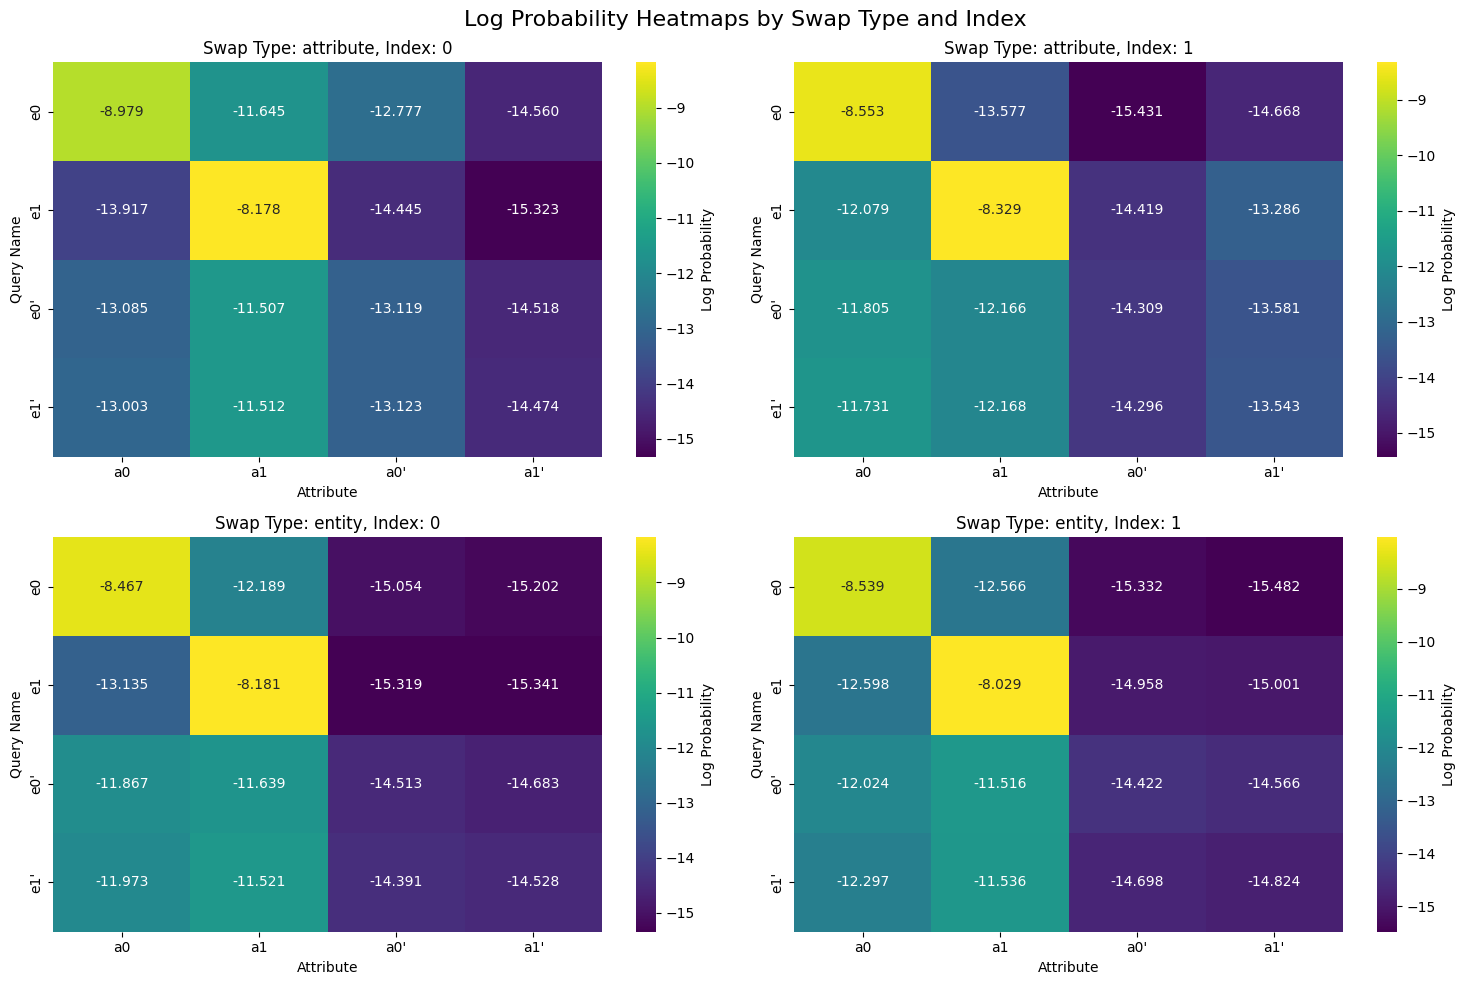

In [29]:
df = pd.read_csv(f"results/{model_alias}/factorizability.csv")
accuracy_df = df.groupby(["query_name", "attribute", "swap_type", "swap_index"]).mean().reset_index()

# Create subplots for each combination of swap_type and swap_index
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Log Probability Heatmaps by Swap Type and Index', fontsize=16)

# Define the order for consistent plotting
attribute_order = ['a0', 'a1', "a0'", "a1'"]
query_order = ['e0', 'e1', "e0'", "e1'"]

# Get unique combinations of swap_type and swap_index
swap_combinations = accuracy_df[['swap_type', 'swap_index']].drop_duplicates().sort_values(['swap_type', 'swap_index'])

for idx, (_, row) in enumerate(swap_combinations.iterrows()):
    swap_type = row['swap_type']
    swap_index = row['swap_index']
    
    # Filter data for this combination
    subset = accuracy_df[(accuracy_df['swap_type'] == swap_type) & (accuracy_df['swap_index'] == swap_index)]
    
    # Create pivot table for heatmap
    pivot_data = subset.pivot(index='query_name', columns='attribute', values='log_prob')
    
    # Reorder according to specified order
    pivot_data = pivot_data.reindex(index=query_order, columns=attribute_order)
    
    # Determine subplot position
    row_idx = idx // 2
    col_idx = idx % 2
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                annot=True, 
                fmt='.3f', 
                cmap='viridis',
                ax=axes[row_idx, col_idx],
                cbar_kws={'label': 'Log Probability'})
    
    axes[row_idx, col_idx].set_title(f'Swap Type: {swap_type}, Index: {swap_index}')
    axes[row_idx, col_idx].set_xlabel('Attribute')
    axes[row_idx, col_idx].set_ylabel('Query Name')

plt.tight_layout()
plt.show()


Not exactly the same as fig 3 in their paper (different model, and we're missing the detail specified at the end of section 3.1), but close.

#### Additivity replication

In [30]:
def modify_outputs(layer: int, target_layers: list[int], pos1: int, pos2: int, original_hidden_states: torch.tensor, delta: torch.tensor):
    """Hook function for adding a delta to the hidden states of a target layer at a target position."""
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            proj_output = output[0]
        else:
            proj_output = output

        proj_output = original_hidden_states[layer].clone()
        if layer in target_layers:
            proj_output[pos1:pos1+2,:] = proj_output[pos1+2,:] + delta[layer,:].clone()
            proj_output[pos2:pos2+2,:] = proj_output[pos2+2,:] - delta[layer,:].clone()

        if isinstance(proj_output, tuple):
            return (proj_output,) + output[1:]
        else:
            return proj_output
    return hook_fn


def modify_hidden_states(ids, model, e0_pos, e1_pos, a0_pos, a1_pos, original_hidden_states, entity_delta, attribute_delta, condition):
    """Modify the hidden states of a model by adding a delta to the original hidden states. Returns model output."""
    hooks = []
    model_layers = model.gpt_neox.layers if "pythia" in model_name else model.model.layers
    for layer in range(len(model_layers)):
        if "pythia" in model_name:
            hidden_state = model_layers[layer].mlp
        else:
            hidden_state = model_layers[layer].post_attention_layernorm
        if condition in ["attribute", "both"]:
            hidden_state_hook_handle = hidden_state.register_forward_hook(modify_outputs(layer, list(range(len(model_layers))), a0_pos, a1_pos, original_hidden_states, attribute_delta))
            hooks.append(hidden_state_hook_handle)
        if condition in ["entity", "both"]:
            hidden_state_hook_handle = hidden_state.register_forward_hook(modify_outputs(layer, list(range(len(model_layers))), e0_pos, e1_pos, original_hidden_states, entity_delta))
            hooks.append(hidden_state_hook_handle)
    with torch.no_grad():
        out = model(
            ids,
            attention_mask=torch.ones_like(ids),
        )
    clear_hooks(hooks)
    return out

In [36]:
# Allocate 'train' and 'test' names and countries for calculating means
train_names = names[:len(names)//2]
test_names = names[len(names)//2:]
train_countries = list(countries_to_capitals.keys())[:len(countries_to_capitals)//2]
test_countries = list(countries_to_capitals.keys())[len(countries_to_capitals)//2:]

# Calculate mean differences
num_runs = 500
attribute_deltas = []
entity_deltas = []
for _ in tqdm.tqdm(range(num_runs)):

    mp, ap = generate_prompt_pair(2, train_names, train_countries)

    for query_entity_idx in range(2):

        main_prompt = mp.context + "\n" + mp.questions[query_entity_idx] + f"\nAnswer: {mp.names[query_entity_idx]} lives in the city of"
        alt_prompt = ap.context + "\n" + ap.questions[query_entity_idx] + f"\nAnswer: {ap.names[query_entity_idx]} lives in the city of"
        
        main_prompt_tokens = tokenizer(main_prompt, return_tensors="pt").to(device)
        alt_prompt_tokens = tokenizer(alt_prompt, return_tensors="pt").to(device)
        main_ids = main_prompt_tokens["input_ids"]
        alt_ids = alt_prompt_tokens["input_ids"]

        main_decoded_tokens = tokenizer.convert_ids_to_tokens(main_prompt_tokens["input_ids"][0])
        alt_decoded_tokens = tokenizer.convert_ids_to_tokens(alt_prompt_tokens["input_ids"][0])
        main_n1_index = main_decoded_tokens.index(f"{space_token}{mp.names[0]}")
        main_n2_index = main_decoded_tokens.index(f"{space_token}{mp.names[1]}")
        main_c1_index = main_decoded_tokens.index(f"{space_token}{mp.countries[0]}")
        main_c2_index = main_decoded_tokens.index(f"{space_token}{mp.countries[1]}")
        alt_n1_index = alt_decoded_tokens.index(f"{space_token}{ap.names[0]}")
        alt_n2_index = alt_decoded_tokens.index(f"{space_token}{ap.names[1]}")
        alt_c1_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[0]}")
        alt_c2_index = alt_decoded_tokens.index(f"{space_token}{ap.countries[1]}")
        if not (main_n1_index == alt_n1_index and main_n2_index == alt_n2_index and main_c1_index == alt_c1_index and main_c2_index == alt_c2_index):
            print("Mismatch in indices")
            continue

        # Get hidden states
        with torch.no_grad():
            main_out, main_hidden_states = save_hidden_states(main_ids, model)
            alt_out, alt_hidden_states = save_hidden_states(alt_ids, model)

        attribute_deltas.append(main_hidden_states[:, main_c2_index:main_c2_index+2, :] - alt_hidden_states[:, alt_c1_index:alt_c1_index+2, :])
        entity_deltas.append(main_hidden_states[:, main_n2_index:main_n2_index+2, :] - alt_hidden_states[:, alt_n1_index:alt_n1_index+2, :])

attribute_deltas = torch.stack(attribute_deltas, dim=0).mean(dim=0)
entity_deltas = torch.stack(entity_deltas, dim=0).mean(dim=0)


# Calculate effect of mean interventions
num_runs = 100
rows = []
for run in tqdm.tqdm(range(num_runs)):

    p, _ = generate_prompt_pair(2, test_names, test_countries)

    for query_entity_idx in range(2):

        prompt = p.context + "\n" + p.questions[query_entity_idx] + f"\nAnswer: {p.names[query_entity_idx]} lives in the city of"

        # Get tokens
        prompt_tokens = tokenizer(prompt, return_tensors="pt").to(device)
        ids = prompt_tokens["input_ids"]
        a1_id = tokenizer(p.answers[0], add_special_tokens=False)["input_ids"][0]
        a2_id = tokenizer(p.answers[1], add_special_tokens=False)["input_ids"][0]

        # Get token positions of entities and attributes
        decoded_tokens = tokenizer.convert_ids_to_tokens(ids[0])
        e0_pos = decoded_tokens.index(f"{space_token}{p.names[0]}")
        e1_pos = decoded_tokens.index(f"{space_token}{p.names[1]}")
        a0_pos = decoded_tokens.index(f"{space_token}{p.countries[0]}")
        a1_pos = decoded_tokens.index(f"{space_token}{p.countries[1]}")

        # control condition
        with torch.no_grad():
            out, original_hidden_states = save_hidden_states(ids, model)
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
        rows.append({
            "run_id": run,
            "condition": "control",
            "query_entity_idx": query_entity_idx,
            "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
            "max_logprob": logprobs.max().item(),
            "a1_token": tokenizer.decode(a1_id),
            "a1_logprob": logprobs[a1_id].item(),
            "a2_token": tokenizer.decode(a2_id),
            "a2_logprob": logprobs[a2_id].item(),
            "correct_answer": "a1" if query_entity_idx == 0 else "a2",
        })

        # Modified conditions
        for condition in ["attribute", "entity", "both"]:
            out = modify_hidden_states(ids, model, e0_pos, e1_pos, a0_pos, a1_pos, original_hidden_states, entity_deltas, attribute_deltas, condition)
            logprobs = F.log_softmax(out.logits[0, -1], dim=-1)
            rows.append({
                "run_id": run,
                "condition": condition,
                "query_entity_idx": query_entity_idx,
                "max_logprob_token": tokenizer.decode(logprobs.argmax().item()),
                "max_logprob": logprobs.max().item(),
                "a1_token": tokenizer.decode(a1_id),
                "a1_logprob": logprobs[a1_id].item(),
                "a2_token": tokenizer.decode(a2_id),
                "a2_logprob": logprobs[a2_id].item(),
                "correct_answer": "a1" if query_entity_idx == 0 else "a2",
            })
    
df = pd.DataFrame(rows)
df.to_csv(f"results/{model_alias}/mean_interventions.csv", index=False)
        
    

100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


In [37]:
def row_is_correct(row):
    return (row["correct_answer"] == "a1" and row["a1_logprob"] > row["a2_logprob"]) or (row["correct_answer"] == "a2" and row["a2_logprob"] > row["a1_logprob"])

for condition, cdf in df.groupby("condition"):
    accuracy = len([1 for _, row in cdf.iterrows() if row_is_correct(row)]) / len(cdf)
    print(f"{condition}: {accuracy}")

attribute: 0.89
both: 0.945
control: 0.94
entity: 0.945
